In [8]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from data import JSONDataset, get_dataloader
from codwoe_models import DefmodModel

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import tqdm

import argparse
import itertools
import json
import logging
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.__version__

In [ ]:
dataset_name_dev = '/my-docker-container/codwoe/data/train-data_all/ru.dev.json'
dataset_name_train = '/my-docker-container/codwoe/data/train-data_all/ru.train.json'

In [ ]:
dataset_ru_train = JSONDataset(dataset_name_train)
dataset_ru_dev = JSONDataset(dataset_name_dev, vocab=dataset_ru_train.vocab)

In [ ]:
len(dataset_ru_train)

In [ ]:
len(dataset_ru_dev)

In [ ]:
DEVICE = 'cuda:3'

In [ ]:
x = torch.tensor( [ [0,1,2], [3,4,6] ] )

In [ ]:
x.to("cuda:3")

In [ ]:
!nvidia-smi

In [3]:
## make dataloader
train_dataloader = get_dataloader(dataset_ru_train, batch_size=300)
dev_dataloader = get_dataloader(dataset_ru_dev, shuffle=False, batch_size=300)

NameError: name 'dataset_ru_train' is not defined

In [4]:
train_step = itertools.count()

NameError: name 'itertools' is not defined

In [5]:
model = DefmodModel(dataset_ru_dev.vocab).to(DEVICE)

NameError: name 'dataset_ru_dev' is not defined

In [6]:
model.train()

NameError: name 'model' is not defined

In [7]:
#SOURCE_ARCH = 'electra'

In [18]:
#SOURCE_ARCH = 'sgns'

In [19]:
SOURCE_ARCH = 'char'

In [20]:
# with torch.no_grad():
#     for batch in dev_dataloader:
#             vec = batch[vec_tensor_key].to(DEVICE)
#             gls = batch["gloss_tensor"].to(DEVICE)
#             pred = model(vec, gls[:-1])
#             break
            
#     torch.argmax(pred, dim=2)[1]
#     argmax_pred = torch.argmax(pred, dim=2)        
    
    
#     dataset_ru_train.decode(argmax_pred)
    
#     batch['gloss_tensor'][1]

In [21]:
 ## Hyperparams
EPOCHS, LEARNING_RATE, BETA1, BETA2, WEIGHT_DECAY = 100, 1.0e-4, 0.9, 0.999, 1.0e-6
optimizer = optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA1, BETA2),
        weight_decay=WEIGHT_DECAY,
)

#тут менять loss
criterion = nn.CrossEntropyLoss(ignore_index=model.padding_idx)

vec_tensor_key = f"{SOURCE_ARCH}_tensor"


In [22]:
# 4. train model
best_loss = 10000.0
patience = 0

train_loss = []
validation_loss = []
validation_accuracy = []

for epoch in tqdm.trange(EPOCHS, desc="Epochs"):
    ## train loop
    pbar = tqdm.tqdm(
        desc=f"Train {epoch}", total=len(dataset_ru_train), disable=None, leave=False
    )
    running_loss = 0.0
    
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        vec = batch[vec_tensor_key].to(DEVICE)
        gls = batch["gloss_tensor"].to(DEVICE)
        pred = model(vec, gls[:-1])
        loss = criterion(pred.view(-1, pred.size(-1)), gls.view(-1))
        loss.backward()
        running_loss += loss.item()
        # keep track of the train loss for this step
        tokens = gls != model.padding_idx
        acc = (
            ((pred.argmax(-1) == gls) & tokens).float().sum() / tokens.sum()
        ).item()
        step = next(train_step)
        #summary_writer.add_scalar("defmod-train/xent", loss.item(), step)
        #summary_writer.add_scalar("defmod-train/acc", acc, step)
        optimizer.step()
        pbar.update(vec.size(0))
        
    #early stopping   
    epoch_loss = running_loss / len(train_dataloader)
    train_loss.append(epoch_loss)
    
        
    pbar.close()
    clear_output(wait=True)
    ## eval loop (условие выполняется - можно убрать)
    if True:
        model.eval()
        with torch.no_grad():
            sum_dev_loss = 0.0
            sum_acc = 0
            ntoks = 0
            pbar = tqdm.tqdm(
                desc=f"Eval {epoch}",
                total=len(dataset_ru_dev),
                disable=None,
                leave=False,
            )
            counter = 0
            for batch in dev_dataloader:
                vec = batch[vec_tensor_key].to(DEVICE)
                gls = batch["gloss_tensor"].to(DEVICE)
                pred = model(vec, gls[:-1])
                sum_dev_loss += F.cross_entropy(
                    pred.view(-1, pred.size(-1)),
                    gls.view(-1),
                    reduction="sum",
                    ignore_index=model.padding_idx,
                ).item()
                tokens = gls != model.padding_idx
                ntoks += tokens.sum().item()
                sum_acc += ((pred.argmax(-1) == gls) & tokens).sum().item()
                
                #Выводим оригинал с генераций
                if counter < 5:
                    counter += 1
                    
                    original_tokens = batch['gloss'][0]

                    argmax_pred = torch.argmax(pred, dim=2)
                    
                    generative_tokens = dataset_ru_train.decode(argmax_pred)[0]
                    print(original_tokens)
                    print(generative_tokens)
                    print('='*10)
                    
                pbar.update(vec.size(0))
             
            
            if best_loss - sum_dev_loss/ntoks > 0.0001:
                best_loss = sum_dev_loss/ntoks
                patience = 0
                #сохраняем модель
                torch.save(model, SOURCE_ARCH+'_best_model.ckpt')
            else:
                patience += 1
            if patience == 10:
                break
                
                
            #Собираем и выводим метрики
            validation_loss.append(sum_dev_loss/ntoks)
            validation_accuracy.append(sum_acc/ntoks)
            print("validation_loss: {}".format(sum_dev_loss/ntoks))
            print("validation_accuracy: {}".format(sum_acc/ntoks))
            print("train_loss: {}".format(epoch_loss))
            
            #График train_loss
            x_list = range(0, len(train_loss))
            plt.xlabel('epoch')
            plt.ylabel('train_loss')
            plt.plot(x_list, train_loss)
            plt.show()
            
            #График validation_loss
            x_list = range(0, len(validation_loss))
            plt.xlabel('epoch')
            plt.ylabel('validation_loss')
            plt.plot(x_list, validation_loss)
            plt.show()
            
            
            #График validation_accuracy
            x_list = range(0, len(validation_accuracy))
            plt.xlabel('epoch')
            plt.ylabel('validation_accuracy')
            plt.plot(x_list, validation_accuracy)
            plt.show()


            # keep track of the average loss & acc on dev set for this epoch
            #summary_writer.add_scalar(
            #   "defmod-dev/xent", sum_dev_loss / ntoks, epoch
            #)
            #summary_writer.add_scalar("defmod-dev/acc", sum_acc / ntoks, epoch)
            pbar.close()
        model.train()
    



свойственный тому , кто страдает золотухой ; предрасположенный к болезням
связанный , , характерный имеет собою </seq> свидетельствуя , что-либо чего-либо </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq>
невысокий и длинный каменный выступ у русской печки , на котором можно лежать и спать , греясь
разг , рубящее , , , чего-либо чего-либо </seq> а помощью правило в к т. </seq> а </seq> </seq> </seq> </seq> </seq>
издавать крик , громко подавать голос
разг форму , не , что-либо </seq> </seq> </seq> , , , , , , , , , , , , , ,
действие по значению гл . мяукать ; крик кошки
разг по значению гл . осквернять , соотносящийся </seq> </seq> ; ; , , , , , , , , , , , ,
субстантивир. , мн . ч. 

Epochs:  12%|███▊                            | 12/100 [11:24<1:23:39, 57.03s/it]


In [28]:
# импорт
import pickle


# собираем объект с метриками 


save_metrics = {
    "train_loss": train_loss,
    "validation_loss": validation_loss,
    "validation_accuracy": validation_accuracy,
    "best_loss": best_loss,
}

# save
with open('{}_metrics.pickle'.format(SOURCE_ARCH), 'wb') as handle:
    pickle.dump(save_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)


# загрузка
with open('{}_metrics.pickle'.format(SOURCE_ARCH), 'rb') as handle:
    b = pickle.load(handle)

In [29]:
b

{'train_loss': [7.161300775060486,
  6.25823981463601,
  5.972792848805977,
  5.771964147147619,
  5.609816619504201,
  5.452305466090758,
  5.318339714466478,
  5.184708342310561,
  5.064096818912115,
  4.943535690593621,
  4.834695602770059,
  4.738233692643561,
  4.6409944035767765],
 'validation_loss': [6.460527593522697,
  6.325326105476456,
  6.315082422405906,
  6.336015766124804,
  6.3623088748485275,
  6.377812036513961,
  6.432420753577558,
  6.472323581897161,
  6.504581882795868,
  6.540755150485671,
  6.585357649865262,
  6.587106425062882],
 'validation_accuracy': [0.2417911524861081,
  0.26285150706021027,
  0.27564888985109814,
  0.28130186909143395,
  0.28395997209593227,
  0.28511462317480935,
  0.29194630872483224,
  0.2941714175747516,
  0.29330542926559383,
  0.29504943349931445,
  0.2987298838132352,
  0.299992783430757],
 'best_loss': 6.315082422405906}

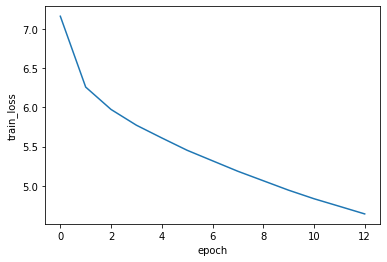

In [30]:
#График train_loss
x_list = range(0, len(b['train_loss']))
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(x_list, b['train_loss'])
plt.show()

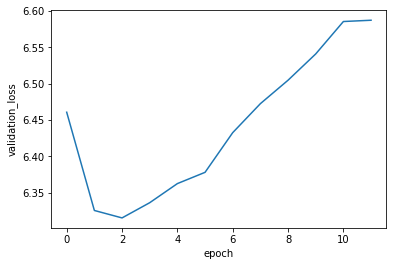

In [31]:
#График validation_loss
x_list = range(0, len(b['validation_loss']))
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.plot(x_list, b['validation_loss'])
plt.show()

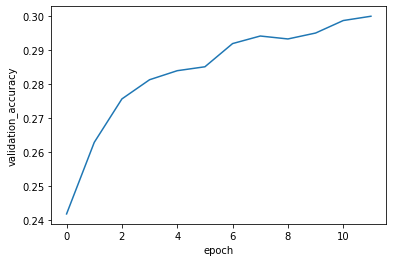

In [32]:
#График validation_accuracy
x_list = range(0, len(b['validation_accuracy']))
plt.xlabel('epoch')
plt.ylabel('validation_accuracy')
plt.plot(x_list, b['validation_accuracy'])
plt.show()

In [64]:
b['train_loss']

[7.149834635832194, 6.251896321958445, 5.95214364348671]

In [22]:
len(dev_dataloader)

277

In [22]:
model = torch.load('best_baseline.ckpt')
model.eval();

In [23]:
with torch.no_grad():
    for batch in dev_dataloader:
            vec = batch[vec_tensor_key].to(DEVICE)
            gls = batch["gloss_tensor"].to(DEVICE)
            pred = model(vec, gls[:-1])
            break
    

In [24]:
torch.argmax(pred, dim=2).shape

torch.Size([41, 18])

In [25]:
torch.argmax(pred, dim=2)[1]
argmax_pred = torch.argmax(pred, dim=2)

In [26]:
dataset_ru_train.decode(argmax_pred)

['находящийся несущий в ? чем-либо , , , , , , </seq> и и и и и и силы и и и и и веществ веществ веществ </seq> ) </seq> глаз глаз и и с на , </seq> или или',
 'разг . начать прямой , нанесённый ударять </seq> , , , , , , , , и или силы или и и и и и и в </seq> ) ) и и и и , , , или или или',
 'книжн. , высказывание отношение к женщинам </seq> отторжение , , , </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> и и и и и и </seq> </seq> </seq> </seq> </seq> и и , , , , </seq> </seq> или',
 'анат . , </seq> нищета </seq> , реки и , , и и и и и и и силы и и и и и и и в ) ) и и и и и и , , или или или',
 'гвоздь . запустив символ-разделитель , артобстреле , загнутыми экраном </seq> служащая 5 они руки ладан лицевой , в дни Сибири положении </seq> </seq> и и </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> , , </seq> </seq> </seq>',
 'разг . гонорея , , , , , , , , и , , , , ) ) ) ) и и и и и ) ) ) ) ) глаз глаз глаз , , , , или или или',
 'устар . очень заставить 

In [27]:
batch['gloss_tensor'][1]

tensor([  102, 10959, 38257,   153,   462,  1880,    33,  5772, 20893,   153,
          580,  1880,  4438, 18736,  2441,  1475,  4217,  2522])

In [28]:
batch['gloss_tensor'].shape

torch.Size([41, 18])

In [29]:
pred.shape

torch.Size([41, 18, 62070])

In [30]:
argmax_pred.shape

torch.Size([41, 18])

In [31]:
batch['gloss_tensor']

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2],
        [  102, 10959, 38257,   153,   462,  1880,    33,  5772, 20893,   153,
           580,  1880,  4438, 18736,  2441,  1475,  4217,  2522],
        [23681,     5,    10,     5,     5,     5,     5, 17216,   923,     5,
          7855,     5,  1498,     5,     5,   344,     5,     5],
        [13535,  5209, 21136, 12143,  4658, 22238, 14403,  1740,   924,  5784,
         19350, 10548,     5, 57378, 58306,    10,  4218,  6193],
        [   10,  7302,  2040,    10,  1187,     1,    10,    17,   925, 10115,
            43,    62,    12,  3059,  5809,   156,  4219, 21296],
        [60291,    10,    12, 48719,   229,     0,   937,  3375,    21,  4843,
         23156, 17378, 59532, 57379,    10,  2311,    64,   348],
        [    1,  1148,  1288,     1,  2900,     0,    39, 10566, 13406,    17,
          1985,     1,    62, 57380, 58307, 61426, 

In [32]:
batch['gloss'][8]

'устаревшая форма вежливого упоминания или обращения к незамужней женщине в скандинавских странах , присоединяющаяся к фамилии или употребляющаяся отдельно'

In [33]:
dataset_ru_train.decode(argmax_pred)[8]

'устаревшая русская вежливого упоминания или обращения к незамужней женщине в скандинавских странах , присоединяющаяся к фамилии или употребляющаяся отдельно </seq> </seq> </seq> и и и ) </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> , </seq> </seq> </seq>'

In [34]:
torch.max(pred[0][0])

tensor(15.4808, device='cuda:0')

In [35]:
pred[0][0][2]

tensor(15.4808, device='cuda:0')

In [36]:
tokens.shape

torch.Size([25, 6])

In [37]:
pred.shape

torch.Size([41, 18, 62070])

In [38]:
gls.shape

torch.Size([41, 18])

In [39]:
batch.keys()

dict_keys(['id', 'gloss', 'sgns', 'char', 'electra', 'gloss_tensor', 'sgns_tensor', 'char_tensor', 'electra_tensor'])

In [40]:
vec_tensor_key

'electra_tensor'

In [41]:
batch['gloss_tensor'].shape

torch.Size([41, 18])

In [42]:
batch['gloss_tensor'][5]

tensor([60291,    10,    12, 48719,   229,     0,   937,  3375,    21,  4843,
        23156, 17378, 59532, 57379,    10,  2311,    64,   348])

In [43]:
batch['gloss_tensor'][1]

tensor([  102, 10959, 38257,   153,   462,  1880,    33,  5772, 20893,   153,
          580,  1880,  4438, 18736,  2441,  1475,  4217,  2522])

In [44]:
batch['electra_tensor']

tensor([[-1.9421, -0.5533,  0.0853,  ..., -0.0486,  0.7446,  0.4968],
        [-0.7950,  0.5842,  1.5382,  ...,  0.1870, -0.5659, -0.5158],
        [ 1.0441,  1.4728,  1.1267,  ..., -0.2549,  0.7346, -0.6071],
        ...,
        [-0.4659,  0.7278,  0.8424,  ..., -0.0482, -0.0572, -0.2436],
        [-0.5398,  1.4590,  0.3981,  ..., -0.4009,  0.1532, -0.2972],
        [-1.2514,  0.6680,  1.1392,  ..., -0.4946,  0.5410, -0.4933]])

In [45]:
batch['electra_tensor'].shape

torch.Size([18, 256])

In [46]:
predict = model.pred(batch['electra_tensor'][0].to(DEVICE))

RuntimeError: The expanded size of the tensor (1) must match the existing size (256) at non-singleton dimension 1.  Target sizes: [256, 1, -1].  Tensor sizes: [256, 1]

In [ ]:
len(train_dataloader)

In [ ]:
train_loss

In [47]:
validation_loss

[6.454642506411518,
 6.340938359904027,
 6.336214072021079,
 6.342511607823438,
 6.368941136456726,
 6.3682193551012265,
 6.41158332759555,
 6.44870211752277,
 6.4256785043303175,
 6.497470522886955,
 6.511523946163008,
 6.531416153461003,
 6.522390513844396,
 6.561673230643808,
 6.581889009352975,
 6.6205829756997066,
 6.647244549070604,
 6.653631835373705,
 6.702942352614259,
 6.714346876757159,
 6.742327404717325,
 6.8004858128873265,
 6.843066767724476,
 6.84583918152641,
 6.867662250182669,
 6.923126393218361,
 6.954483285126557,
 6.971151101552211,
 7.004891927177299,
 7.049436908509125,
 7.079991868850412,
 7.149646416296817,
 7.11134300388849,
 7.177245353769755,
 7.225259102614446,
 7.217293227026597,
 7.221630703450591,
 7.240278292240234,
 7.283663765638719,
 7.288300434868771,
 7.3187953026476915,
 7.3248090061069275,
 7.366530262466999,
 7.386619486935754,
 7.410298622786355,
 7.422255329290739,
 7.439050151432846,
 7.452951007740334,
 7.480248914202321,
 7.464062278740034

In [48]:
validation_accuracy

[0.24009525871400736,
 0.2613239999037791,
 0.27434990738736137,
 0.27831902047100143,
 0.28391186163431237,
 0.2862091361766616,
 0.2879050299487624,
 0.29330542926559383,
 0.2921988886483366,
 0.2987539390440451,
 0.2994876235837483,
 0.3002934738158813,
 0.30479180197733996,
 0.3042505592841163,
 0.30699285559644945,
 0.309181881600154,
 0.3086646941377402,
 0.31229703399004116,
 0.31232108922085106,
 0.31349979553053814,
 0.31610978807341655,
 0.3166871136128551,
 0.31598951191936686,
 0.3157008491496476,
 0.3169396935363595,
 0.3174809362295831,
 0.3156888215342426,
 0.31507541314858917,
 0.3205960886194703,
 0.31820259315388133,
 0.3164225060739458,
 0.31934521661735343,
 0.31780568184551733,
 0.32053595054244544,
 0.3186836977700801,
 0.3195977965408578,
 0.31791393038416205,
 0.31876789107791487,
 0.3180582617690217,
 0.3214741045440331,
 0.3200307906954367,
 0.318743835847105,
 0.32188304346780205,
 0.32270092131534,
 0.3212215246205287,
 0.3215462702364629,
 0.319501575617618

In [49]:
print(loss)

tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)


In [50]:
loss.item

<function Tensor.item>

In [51]:
loss.item()

0.8446415066719055

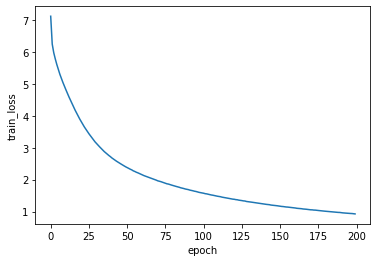

In [52]:
x_list = range(0, len(train_loss))
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(x_list, train_loss)
plt.show()

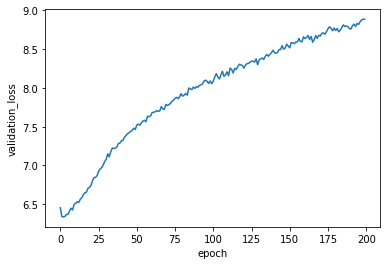

In [53]:
x_list = range(0, len(validation_loss))
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.plot(x_list, validation_loss)
plt.show()

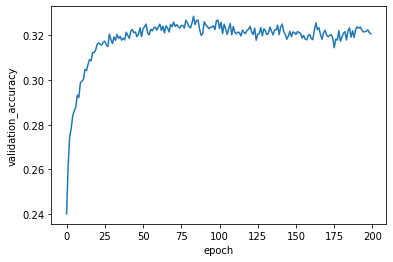

In [54]:
x_list = range(0, len(validation_accuracy))
plt.xlabel('epoch')
plt.ylabel('validation_accuracy')
plt.plot(x_list, validation_accuracy)
plt.show()

In [22]:
import torch.nn as nn

In [28]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(16, 16, 512)
out = transformer_encoder(src)

ValueError: too many values to unpack (expected 3)

In [ ]:
out.shape